In [112]:
#================================================================================== Entrainements modèles sur Tasmanie & Norfolk Island
# Evaluation des modèles sur données oversamplées ou pas pour comparer les résultats
# Calcul coef de Pearson
# HeatMap
# Utilisation de MinMaxScaler
# Identification des meilleures features
# Enfin évaluation des séries temporelles ==> Echec suite allocation mémoire impossible

In [113]:
%run Code_Commun.ipynb

In [114]:
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold, GridSearchCV
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api 
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

In [115]:
df=pd.read_csv('WeatherAUSRegionTAS.csv',sep=';')
df2=pd.read_csv('WeatherAUSRegionNIS.csv',sep=';')

In [116]:
dfW=pd.concat([df,df2],ignore_index=True)
dfW.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Humidity9am,...,Pressure9am,Pressure3pm,RainToday,RainTomorrow,year,month,day,week,Radar,Region
0,2009-01-01,Richmond,12.0,33.1,0.0,9.8,12.9,W,61.0,63.0,...,1005.5,1001.0,No,No,2009,1,1,1,SydneyAirport,Tasmania
1,2009-01-02,Richmond,15.9,25.8,0.0,19.0,5.9,SE,50.0,63.0,...,1012.6,1012.1,No,No,2009,1,2,1,SydneyAirport,Tasmania
2,2009-01-03,Richmond,13.6,20.8,0.0,9.0,0.5,E,24.0,52.0,...,1021.9,1019.1,No,No,2009,1,3,1,SydneyAirport,Tasmania
3,2009-01-04,Richmond,16.3,30.1,0.0,5.4,11.3,NE,33.0,60.0,...,1018.7,1013.5,No,No,2009,1,4,1,SydneyAirport,Tasmania
4,2009-01-05,Richmond,14.6,36.5,0.0,15.2,12.2,W,57.0,58.0,...,1013.1,1007.7,No,No,2009,1,5,2,SydneyAirport,Tasmania


In [117]:
dfW=df.drop('Date',axis=1)

In [118]:
len(dfW)

5905

In [119]:
ReplaceRain(dfW)
dfW.head()

Variables remplacées


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,year,month,day,week,Radar,Region
0,Richmond,12.0,33.1,0.0,9.8,12.9,W,61.0,63.0,13.0,1005.5,1001.0,0,0,2009,1,1,1,SydneyAirport,Tasmania
1,Richmond,15.9,25.8,0.0,19.0,5.9,SE,50.0,63.0,58.0,1012.6,1012.1,0,0,2009,1,2,1,SydneyAirport,Tasmania
2,Richmond,13.6,20.8,0.0,9.0,0.5,E,24.0,52.0,50.0,1021.9,1019.1,0,0,2009,1,3,1,SydneyAirport,Tasmania
3,Richmond,16.3,30.1,0.0,5.4,11.3,NE,33.0,60.0,51.0,1018.7,1013.5,0,0,2009,1,4,1,SydneyAirport,Tasmania
4,Richmond,14.6,36.5,0.0,15.2,12.2,W,57.0,58.0,52.0,1013.1,1007.7,0,0,2009,1,5,2,SydneyAirport,Tasmania


In [120]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in dfW.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    dfW[col] = lencoders[col].fit_transform(dfW[col])

In [121]:
dfW=dfW.drop('week',axis=1)

In [187]:
#Test Pearson entre variables quantitatives

In [122]:
#=== Tests de Pearson sur toutes les variables identifiées plus bas
ListeVar=['MinTemp', 'MaxTemp', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
for features in ListeVar:
    coeff,pval=pearsonr(dfW['RainTomorrow'],dfW[features])
    print(f"Pour {features} le coeff est égal à {coeff} et la pvalue à {pval}")

Pour MinTemp le coeff est égal à 0.14500091424102468 et la pvalue à 4.1085582381685134e-29
Pour MaxTemp le coeff est égal à -0.11683321226105031 et la pvalue à 2.119822399084492e-19
Pour Sunshine le coeff est égal à -0.4164423835456098 et la pvalue à 1.8040035041930372e-246
Pour WindGustSpeed le coeff est égal à 0.16128177488865567 et la pvalue à 1.05270322996802e-35
Pour Humidity9am le coeff est égal à 0.16205168525226107 et la pvalue à 4.927271371448946e-36
Pour Humidity3pm le coeff est égal à 0.4405851794449349 et la pvalue à 5.4518730383882e-279
Pour Pressure9am le coeff est égal à -0.2509928028280047 et la pvalue à 1.6166421420767738e-85
Pour Pressure3pm le coeff est égal à -0.24878304198248843 et la pvalue à 5.276472486550374e-84


In [123]:
#Variables qualitatives et quantitatives : Anova
# p-value < 5% donc on rejette H0
# quanti puis quali dans paramètre
result = statsmodels.formula.api.ols('RainTomorrow ~ WindGustSpeed', data=dfW).fit()
table = statsmodels.api.stats.anova_lm(result)
table
#H0 WindGustDir n'influe pas sur RainTomorrow 
#la p-value (PR(>F)) est inférieur à 5% donc on rejette l'hypothèse 
#La vitesse du vent influe sur RainTomorrow

,df,sum_sq,mean_sq,F,PR(>F)
WindGustSpeed,1.0,25.900434,25.900434,157.648441,1.052703e-35
Residual,5903.0,969.817771,0.164292,NaN,NaN


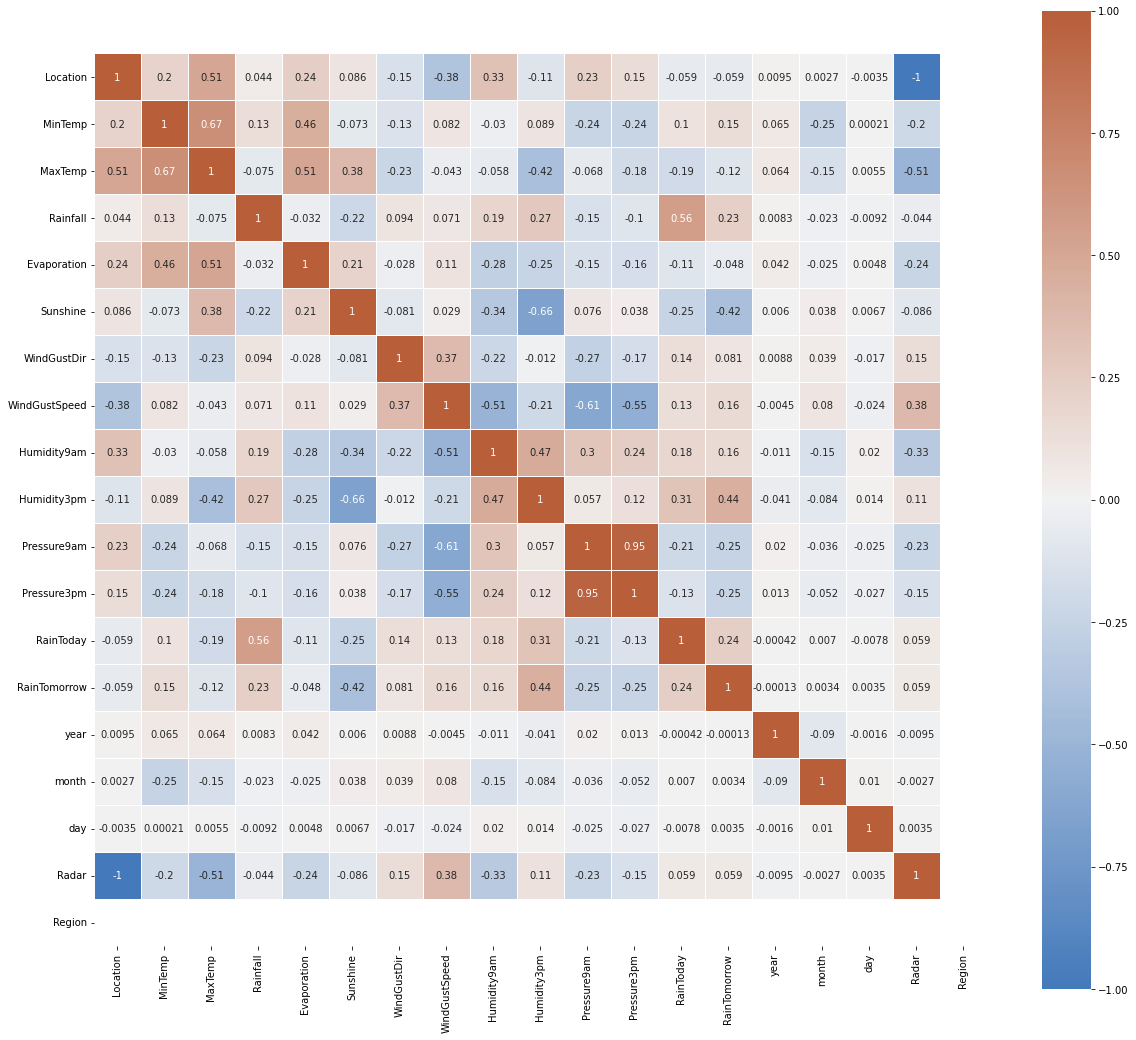

In [124]:
# Correlation Heatmap
import seaborn as sns
corr = dfW.corr()
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})
sns.heatmap(corr, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})
plt.show()

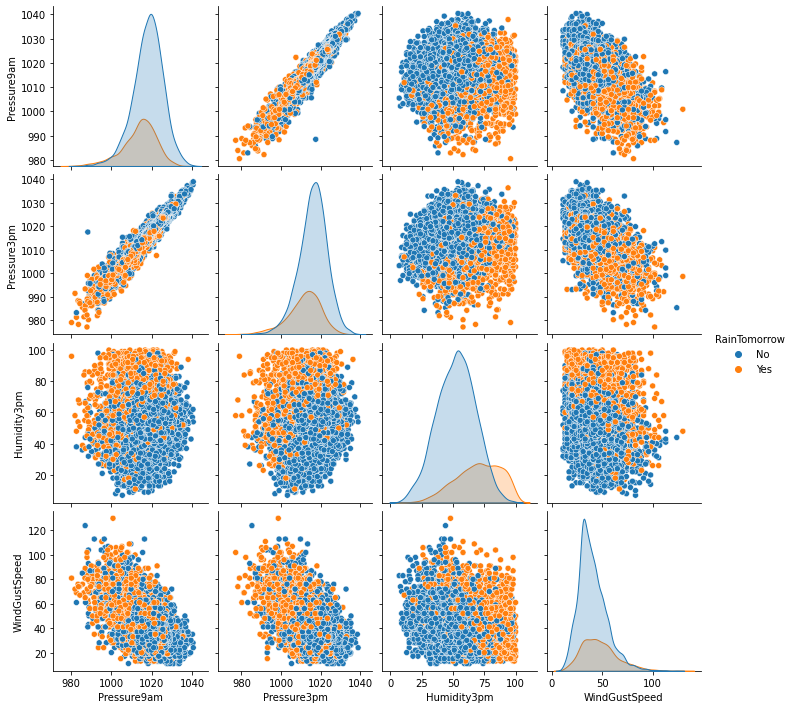

In [37]:
sns.pairplot(data=dfW, vars=('Pressure9am','Pressure3pm','Humidity3pm','WindGustSpeed'), hue='RainTomorrow' )
plt.show()

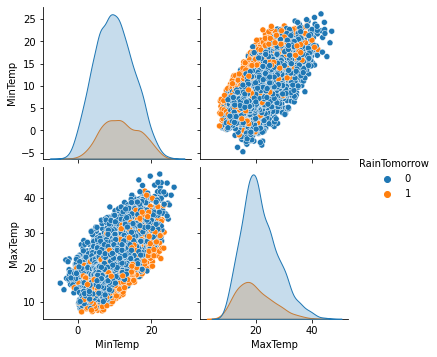

In [125]:
sns.pairplot(data=dfW, vars=('MinTemp','MaxTemp'), hue='RainTomorrow' )
plt.show()

In [ ]:
#============================================================================================== Avant d'entrainer les modèle

In [126]:
scaler = MinMaxScaler().fit(dfW)
modified_data = pd.DataFrame(scaler.transform(dfW), index=dfW.index, columns=dfW.columns)

In [127]:
X = modified_data.drop('RainTomorrow',axis=1)
y = modified_data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [128]:
#Random Oversampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {0.0: 3479, 1.0: 3479}


In [129]:
selector = SelectKBest(f_regression, k=7)
selector.fit(X_ro, y_ro)
X_new = selector.transform(X_ro)
print(X_ro.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'RainToday'],
      dtype='object')


In [21]:
# ==================================================================================================== Entrainements modeles

In [ ]:
#====================================================== Logistic Regression over sampled

In [130]:
lr_tasnis = LogisticRegression() 
parameters = {'C':[0.1, 1, 2, 3, 5, 8, 13, 21, 34],
              'solver':['sag', 'saga', 'lbfgs'],
             'max_iter':[1000],
             'random_state' : [66]}

grid_lr_TASNIS = GridSearchCV(estimator=lr_tasnis, param_grid=parameters)
grille = grid_lr_TASNIS.fit(X_ro, y_ro)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print ('Best params:', grid_lr_TASNIS.best_params_)
#Best params: {'C': 8, 'solver': 'sag'}

                                               params  mean_test_score
0   {'C': 0.1, 'max_iter': 1000, 'random_state': 6...         0.780971
1   {'C': 0.1, 'max_iter': 1000, 'random_state': 6...         0.780971
2   {'C': 0.1, 'max_iter': 1000, 'random_state': 6...         0.780971
3   {'C': 1, 'max_iter': 1000, 'random_state': 66,...         0.783415
4   {'C': 1, 'max_iter': 1000, 'random_state': 66,...         0.783415
5   {'C': 1, 'max_iter': 1000, 'random_state': 66,...         0.783415
6   {'C': 2, 'max_iter': 1000, 'random_state': 66,...         0.783990
7   {'C': 2, 'max_iter': 1000, 'random_state': 66,...         0.783990
8   {'C': 2, 'max_iter': 1000, 'random_state': 66,...         0.783990
9   {'C': 3, 'max_iter': 1000, 'random_state': 66,...         0.783990
10  {'C': 3, 'max_iter': 1000, 'random_state': 66,...         0.783990
11  {'C': 3, 'max_iter': 1000, 'random_state': 66,...         0.783990
12  {'C': 5, 'max_iter': 1000, 'random_state': 66,...         0.783415
13  {'

In [135]:
lr_tasnis = LogisticRegression(C=8, solver='sag',max_iter=1000,random_state=66) 
lr_tasnis.fit(X_ro, y_ro)
y_pred_lr=lr_tasnis.predict(X_test)

In [136]:
pd.crosstab(y_test, y_pred_lr)

col_0,0.0,1.0
RainTomorrow,,
0.0,936,222
1.0,81,238


In [137]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      1158
         1.0       0.52      0.75      0.61       319

    accuracy                           0.79      1477
   macro avg       0.72      0.78      0.74      1477
weighted avg       0.83      0.79      0.81      1477



In [ ]:
#================================================== KNN over sampled

In [138]:
knn=KNeighborsClassifier()
param_knn={'n_neighbors':[1,2,3,5,8,13,21,34,55],'metric':['euclidean','minkowski','manhattan']}
grid_knn_TASNIS=GridSearchCV(estimator=knn,param_grid=param_knn)
grille_knn=grid_knn_TASNIS.fit(X_ro,y_ro)
print('Best params :',grid_knn_TASNIS.best_params_)

Best params : {'metric': 'manhattan', 'n_neighbors': 1}


In [139]:
print(pd.DataFrame.from_dict(grille_knn.cv_results_).loc[:,['params', 'mean_test_score']])

                                        params  mean_test_score
0    {'metric': 'euclidean', 'n_neighbors': 1}         0.909746
1    {'metric': 'euclidean', 'n_neighbors': 2}         0.871660
2    {'metric': 'euclidean', 'n_neighbors': 3}         0.842340
3    {'metric': 'euclidean', 'n_neighbors': 5}         0.808135
4    {'metric': 'euclidean', 'n_neighbors': 8}         0.787299
5   {'metric': 'euclidean', 'n_neighbors': 13}         0.781547
6   {'metric': 'euclidean', 'n_neighbors': 21}         0.782984
7   {'metric': 'euclidean', 'n_neighbors': 34}         0.777812
8   {'metric': 'euclidean', 'n_neighbors': 55}         0.771775
9    {'metric': 'minkowski', 'n_neighbors': 1}         0.909746
10   {'metric': 'minkowski', 'n_neighbors': 2}         0.871660
11   {'metric': 'minkowski', 'n_neighbors': 3}         0.842340
12   {'metric': 'minkowski', 'n_neighbors': 5}         0.808135
13   {'metric': 'minkowski', 'n_neighbors': 8}         0.787299
14  {'metric': 'minkowski', 'n_neighbors

In [46]:
# == BestParams KNN : manhattan et 1

In [140]:
knn_tasnis=KNeighborsClassifier(n_neighbors = 1,metric='manhattan')
knn_tasnis.fit(X_ro,y_ro)
y_pred_tasnis=knn_tasnis.predict(X_test)

In [141]:
pd.crosstab(y_test, y_pred_tasnis)

col_0,0.0,1.0
RainTomorrow,,
0.0,1012,146
1.0,160,159


In [142]:
print(classification_report(y_test, y_pred_tasnis))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      1158
         1.0       0.52      0.50      0.51       319

    accuracy                           0.79      1477
   macro avg       0.69      0.69      0.69      1477
weighted avg       0.79      0.79      0.79      1477



In [ ]:
#============================================== Random Forest over sampled

In [143]:
rfclf = RandomForestClassifier(n_jobs = -1)
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [66]
}

grid_rfclf_TASNIS = GridSearchCV(estimator=rfclf, param_grid=parameters)
grille = grid_rfclf_TASNIS.fit(X_ro, y_ro)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

print ('Best params:', grid_rfclf_TASNIS.best_params_)
#Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}

                                               params  mean_test_score
0   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.786434
1   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.787584
2   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.786434
3   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.787584
4   {'criterion': 'gini', 'max_depth': 5, 'max_fea...         0.800087
5   {'criterion': 'gini', 'max_depth': 5, 'max_fea...         0.799800
6   {'criterion': 'gini', 'max_depth': 5, 'max_fea...         0.800087
7   {'criterion': 'gini', 'max_depth': 5, 'max_fea...         0.799800
8   {'criterion': 'gini', 'max_depth': 6, 'max_fea...         0.813885
9   {'criterion': 'gini', 'max_depth': 6, 'max_fea...         0.814891
10  {'criterion': 'gini', 'max_depth': 6, 'max_fea...         0.813885
11  {'criterion': 'gini', 'max_depth': 6, 'max_fea...         0.814891
12  {'criterion': 'gini', 'max_depth': 7, 'max_fea...         0.838317
13  {'

In [144]:
rf_tasnis = RandomForestClassifier(n_jobs = -1, criterion='gini',max_depth=8, n_estimators=200, max_features='sqrt',random_state=66)
rf_tasnis.fit(X_ro,y_ro)
y_pred_rf_tasnis=rf_tasnis.predict(X_test)

In [145]:
pd.crosstab(y_test, y_pred_rf_tasnis)

col_0,0.0,1.0
RainTomorrow,,
0.0,965,193
1.0,90,229


In [146]:
print(classification_report(y_test, y_pred_rf_tasnis))

              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      1158
         1.0       0.54      0.72      0.62       319

    accuracy                           0.81      1477
   macro avg       0.73      0.78      0.75      1477
weighted avg       0.83      0.81      0.82      1477



In [ ]:
#======================================================================== TESTS AVEC DONNEES NON  OVER SAMPLED

In [ ]:
#=============================== Logistic Regression non over sampled

In [147]:
lr_tasnis_nov = LogisticRegression(C=2, solver='sag',max_iter=1000,random_state=66) 
lr_tasnis_nov.fit(X_train, y_train)
y_pred_lr2_nov=lr_tasnis_nov.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_lr2_nov))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.88      0.96      0.51      0.91      0.70      0.51      1158
        1.0       0.76      0.51      0.96      0.61      0.70      0.46       319

avg / total       0.85      0.86      0.60      0.85      0.70      0.50      1477



In [148]:
pd.crosstab(y_test, y_pred_lr2_nov)

col_0,0.0,1.0
RainTomorrow,,
0.0,1106,52
1.0,157,162


In [ ]:
#=============================== KNN non over sampled

In [149]:
knn_tasnis_nov=KNeighborsClassifier(n_neighbors = 1,metric='manhattan')
knn_tasnis_nov.fit(X_train,y_train)
y_pred_tasnis_nov=knn_tasnis_nov.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_tasnis_nov))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.86      0.87      0.50      0.87      0.66      0.45      1158
        1.0       0.52      0.50      0.87      0.51      0.66      0.42       319

avg / total       0.79      0.79      0.58      0.79      0.66      0.44      1477



In [150]:
pd.crosstab(y_test, y_pred_tasnis_nov)

col_0,0.0,1.0
RainTomorrow,,
0.0,1012,146
1.0,160,159


In [57]:
#=============================== Random Forest non over sampled

In [151]:
rf_tasnis_nov = RandomForestClassifier(n_jobs = -1, criterion='gini',max_depth=8, n_estimators=200, max_features='sqrt', random_state=66)
rf_tasnis_nov.fit(X_train,y_train)
y_pred_rf_tasnis_nov=rf_tasnis_nov.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf_tasnis_nov))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.87      0.96      0.48      0.91      0.68      0.48      1158
        1.0       0.76      0.48      0.96      0.58      0.68      0.43       319

avg / total       0.84      0.85      0.58      0.84      0.68      0.47      1477



In [152]:
pd.crosstab(y_test, y_pred_rf_tasnis_nov)

col_0,0.0,1.0
RainTomorrow,,
0.0,1109,49
1.0,167,152


In [169]:
# Neural Network de sklearn, pas assez de temps pour bien appréhender le module 151
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

params_nn = {'hidden_layer_sizes': (10,10,10),
             'activation': 'tanh',
             'solver': 'adam',
             'max_iter': 1000}

model_nn = MLPClassifier(**params_nn)
model_nn.fit(X_ro,y_ro)
y_pred_mlp = model_nn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_mlp)
roc_auc = roc_auc_score(y_test, y_pred_mlp) 
print("Accuracy = {}".format(accuracy))
print("ROC  = {}".format(roc_auc))
print(classification_report(y_test,y_pred_mlp,digits=5))

Accuracy = 0.7982396750169262
ROC  = 0.7759378671474437
              precision    recall  f1-score   support

         0.0    0.91829   0.81520   0.86368      1158
         1.0    0.52339   0.73668   0.61198       319

    accuracy                        0.79824      1477
   macro avg    0.72084   0.77594   0.73783      1477
weighted avg    0.83300   0.79824   0.80932      1477



In [170]:
pd.crosstab(y_test, y_pred_mlp, rownames = ['Classe réelle'], colnames = ['Classe prédite par nn'])

Classe prédite par nn,0.0,1.0
Classe réelle,,
0.0,944,214
1.0,84,235


In [62]:
#===== Après tests communs nous avons décidé de rester sur des données oversamplées

In [ ]:
#=======================================================================================================================

In [ ]:
#======================================= Select des meilleures features sur données over sampled ==================================================

['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
[0.02398284 0.01087152 0.03287836 0.02996549 0.04356119 0.02505153
 0.20576788 0.02034178 0.05722549 0.04811743 0.27532199 0.06061022
 0.08268644 0.023962   0.00934069 0.01350125 0.01972377 0.01036785
 0.00672228]


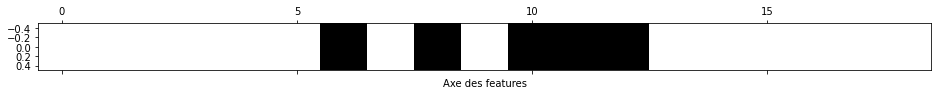

In [60]:
selector = SelectFromModel(rf_tasnis)
sel=selector.fit(X_ro, y_ro)
mask = selector.get_support()
features = X_ro.loc[:,mask].columns.tolist()
print(features)
print(rf_tasnis.fit(X_ro,y_ro).feature_importances_)
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']


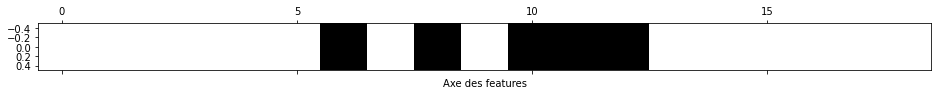

In [61]:
selector = SelectFromModel(lr_tasnis)
sel=selector.fit(X_ro, y_ro)
mask = selector.get_support()
features = X_ro.loc[:,mask].columns.tolist()
print(features)
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [240]:
selector = SelectFromModel(knn_tasnis)
selector.fit(X_ro, y_ro)
print(features)


['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']


In [ ]:
#==========================================================================================================================================

In [ ]:
#=============================================================== SERIE TEMPORELLE =======================================================

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from calendar import monthrange
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [89]:
df_tas = pd.read_csv('WeatherAUSRegionNISDate.csv', header=0, parse_dates=[0], index_col=0, sep=';').squeeze("columns")
df_tas.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,year,month,day,week,Radar,Region
Date,,,,,,,,,,,,,,,,,,,,
2009-01-01,NorfolkIsland,20.4,25.8,0.0,6.0,12.4,NNW,31.0,84.0,71.0,1014.5,1013.6,No,No,2009,1,1,1,Hobart,New South Wales
2009-01-02,NorfolkIsland,20.9,26.7,0.2,8.0,10.3,N,31.0,79.0,77.0,1016.3,1015.5,No,No,2009,1,2,1,Hobart,New South Wales
2009-01-03,NorfolkIsland,22.3,26.3,0.0,3.2,2.0,E,35.0,87.0,90.0,1014.6,1014.3,No,Yes,2009,1,3,1,Hobart,New South Wales
2009-01-04,NorfolkIsland,21.6,22.2,1.2,2.8,0.0,ESE,41.0,92.0,95.0,1016.0,1015.3,Yes,Yes,2009,1,4,1,Hobart,New South Wales
2009-01-05,NorfolkIsland,20.4,23.5,2.6,2.2,2.9,ESE,52.0,86.0,86.0,1015.3,1013.7,Yes,No,2009,1,5,2,Hobart,New South Wales


In [90]:
df_tas = df_tas.drop(df_tas[df_tas['year'] == 2009].index)

In [91]:
df_tas = df_tas.drop(df_tas[df_tas['year'] == 2017].index)

In [92]:
df_tas=df_tas.drop('Location',axis=1)
df_tas=df_tas.drop('week',axis=1)
df_tas=df_tas.drop('Radar',axis=1)
df_tas=df_tas.drop('Region',axis=1)

In [93]:
df_tas=df_tas.drop('RainToday',axis=1)
df_tas=df_tas.drop('RainTomorrow',axis=1)

In [47]:
df_tas.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2016-12-07', '2016-12-08', '2016-12-12', '2016-12-13',
               '2016-12-14', '2016-12-15', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22'],
              dtype='datetime64[ns]', name='Date', length=2438, freq=None)

In [94]:
df_tas=df_tas.drop('year',axis=1)
df_tas=df_tas.drop('month',axis=1)
df_tas=df_tas.drop('day',axis=1)
todrop=['Rainfall','WindGustSpeed','Evaporation','Sunshine','WindGustDir','Humidity9am','Pressure9am','Humidity3pm','Pressure3pm']
df_tas=df_tas.drop(todrop,axis=1)

In [49]:
df_tas.head()

,MinTemp,MaxTemp
Date,,
2010-01-01,18.6,24.5
2010-01-02,19.3,25.2
2010-01-03,20.7,26.4
2010-01-04,20.2,26.7
2010-01-05,20.9,24.7


In [95]:
df1=df_tas.drop('MinTemp',axis=1)
df2=df_tas.drop('MaxTemp',axis=1)

In [96]:
df1.sort_index(inplace=True)
df2.sort_index(inplace=True)

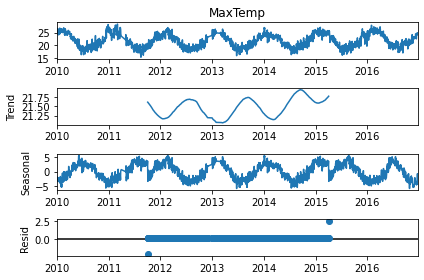

In [100]:
res1 = seasonal_decompose(x=df1['MaxTemp'], model='additive',period = int(len(df1)/2))
res1.plot()
plt.show()

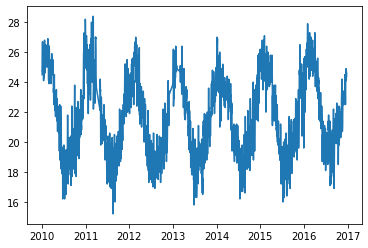

In [97]:
plt.plot(df1)
plt.show()

In [111]:
data = pd.read_csv('WeatherAUSRegionNISDate.csv', header=0, parse_dates=[0], index_col=0, sep=';').squeeze("columns")
data = data.drop(data[data['year'] == 2009].index)
data = data.drop(data[data['year'] == 2017].index)
data=data.drop('Location',axis=1)
data=data.drop('week',axis=1)
data=data.drop('Radar',axis=1)
data=data.drop('Region',axis=1)
data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,year,month,day
Date,,,,,,,,,,,,,,,,
2010-01-01,18.6,24.5,0.0,7.4,5.2,E,50.0,53.0,55.0,1021.5,1019.6,No,No,2010,1,1
2010-01-02,19.3,25.2,0.0,7.2,12.6,NE,35.0,77.0,73.0,1019.2,1017.6,No,No,2010,1,2
2010-01-03,20.7,26.4,0.0,6.8,12.2,NNE,37.0,73.0,70.0,1016.9,1015.4,No,No,2010,1,3
2010-01-04,20.2,26.7,0.0,7.0,9.1,WNW,30.0,70.0,65.0,1015.4,1015.0,No,No,2010,1,4
2010-01-05,20.9,24.7,0.0,6.0,0.9,ESE,41.0,85.0,79.0,1017.8,1017.1,No,No,2010,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15,15.7,24.3,0.0,6.2,11.7,ENE,30.0,53.0,61.0,1019.0,1017.9,No,No,2016,12,15
2016-12-19,17.8,24.9,0.8,19.6,5.5,E,30.0,77.0,65.0,1015.5,1014.0,No,No,2016,12,19
2016-12-20,19.8,24.1,0.4,6.4,7.8,E,48.0,74.0,81.0,1015.9,1015.0,No,Yes,2016,12,20


In [110]:
len(df1)

2438

In [ ]:
 #Evaluer la stationnarité de la série et la rendre stationnaire si pas

In [120]:
result=adfuller(df1)
print('stat ADF',result[0])
print('pvalue', result[1])

stat ADF -2.7612030271664523
pvalue 0.06403289931169762
1% -3.4330505934142805
5% -2.8627330913837
10% -2.5674051315298607


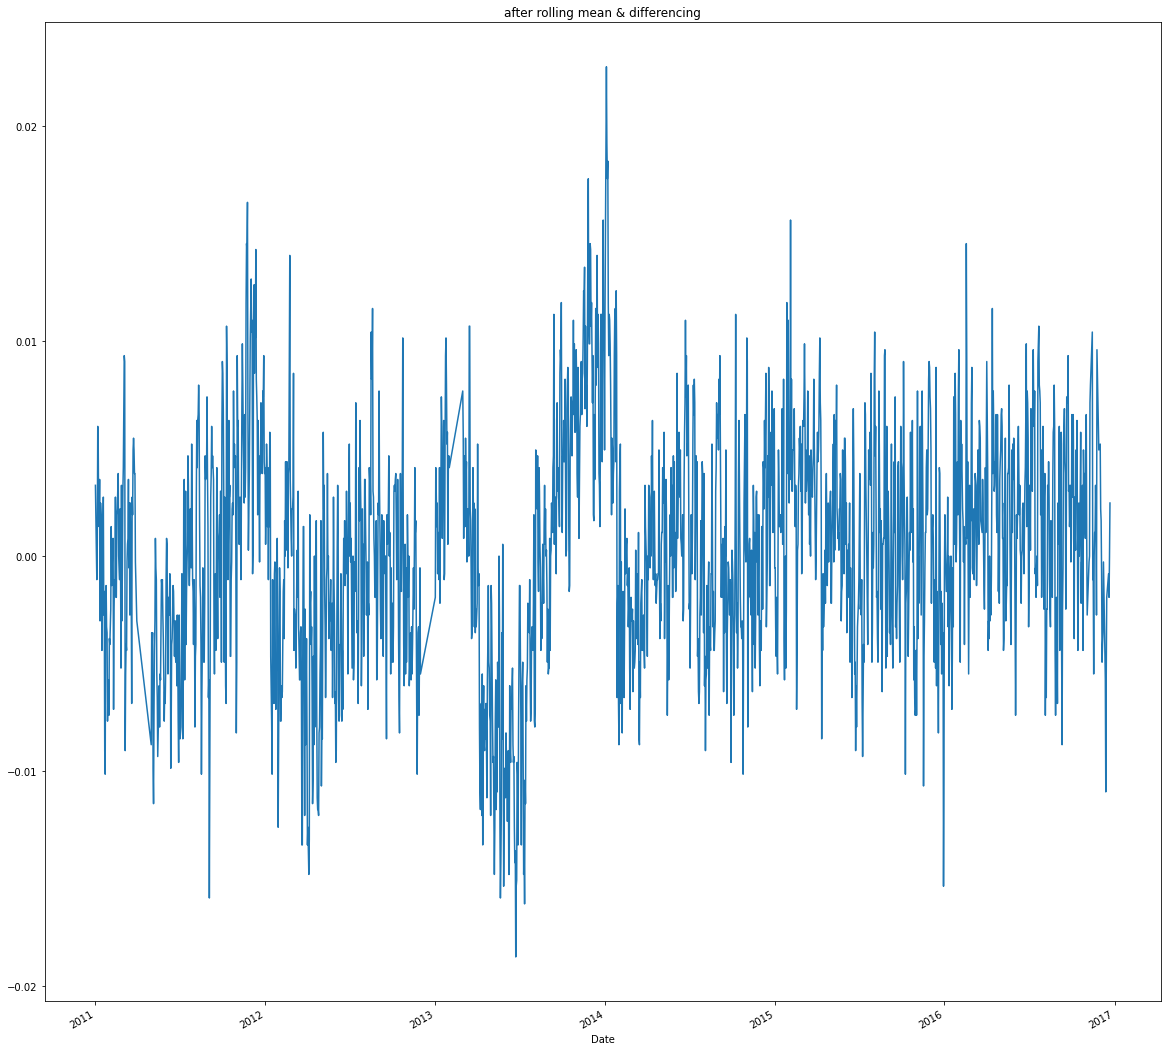

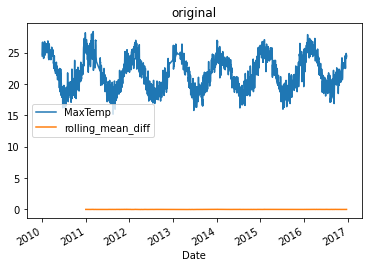

In [161]:
df1=df1.drop('rolling_mean_diff',axis=1)
rolling_mean = df1.rolling(window = 365).mean()
df1['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df1['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df1.plot(title='original');

In [163]:
result=adfuller(df1['rolling_mean_diff'].dropna())
print('stat ADF',result[0])
print('pvalue', result[1])

stat ADF -4.813686312236975
pvalue 5.120040507510151e-05


In [167]:
df1_final = df1['rolling_mean_diff'].dropna()

In [ ]:
#la série est stationnaire OK pvalue<5%

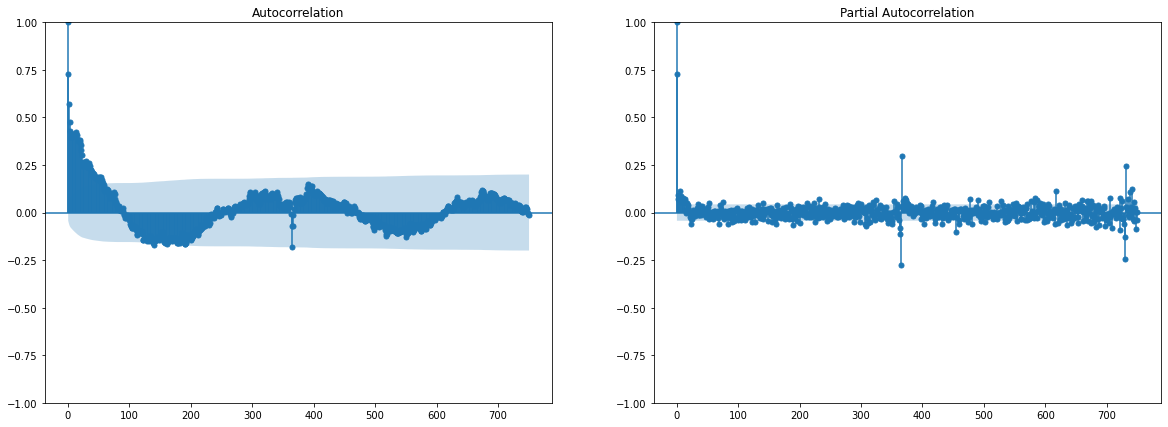

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(df1_final, lags = 750, ax=ax1)
plot_pacf(df1_final, lags = 750, ax=ax2)
plt.show()


In [175]:
model=sm.tsa.statespace.SARIMAX(df1['MaxTemp'],order=(1, 1, 1),seasonal_order=(1,1,1,365))
results=model.fit()

C:\Users\rblv6364\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rblv6364\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MemoryError: Unable to allocate 9.76 GiB for an array with shape (733, 733, 2439) and data type float64

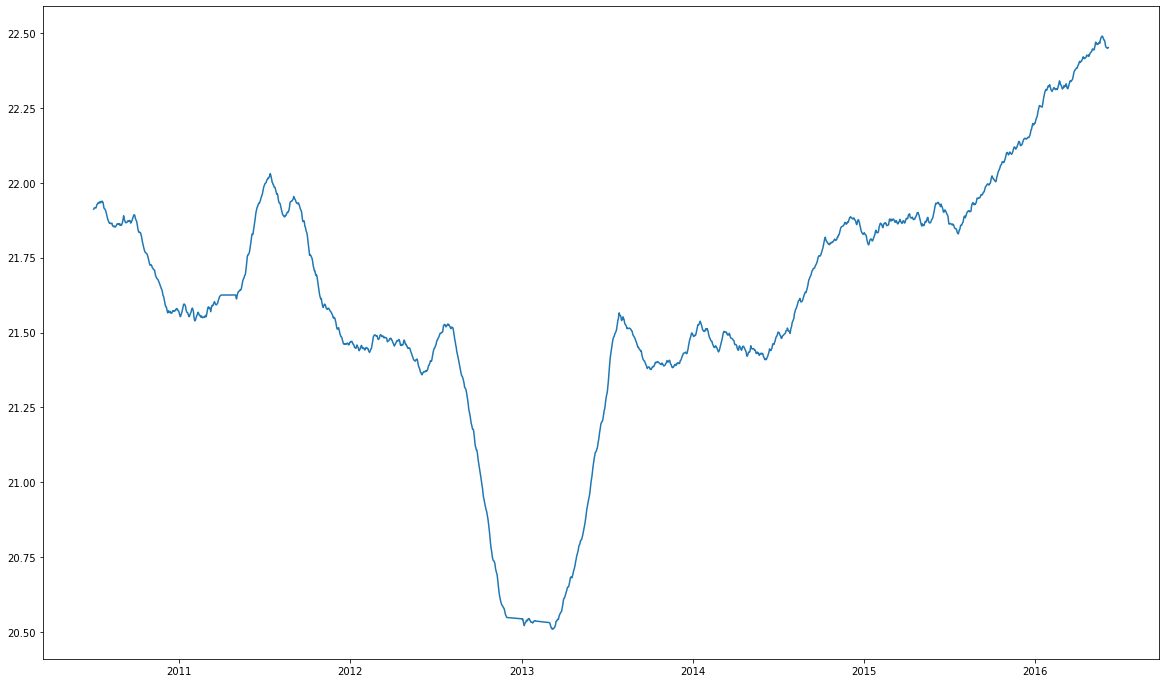

In [173]:
plt.figure(figsize=(20,12))
plt.plot(df1['MaxTemp'].rolling(365, center=True).mean(),label="unweighted")

In [66]:
# Année 2013 anormale constatée dans tous les essais, nous avons fait des essais en ne prenant que 2014 à 2017, mais nouvel échec pour allocation de mémoire

In [63]:
# ============== Echecs pour tous sur les séries temporelles, nous les abandonnons

In [64]:
# ====== FIN